In [43]:
import numpy as np
import torch
import gym
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


In [44]:
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, input): return mish(input)

In [45]:
# helper function to convert numpy arrays to tensors
def t(x):
    x = np.array(x) if not isinstance(x, np.ndarray) else x
    return torch.from_numpy(x).float()

In [46]:
# Actor module, categorical actions only
import math
leaky = torch.nn.LeakyReLU()

# std = nn.Parameter(t([0.1]))
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.n_actions = n_actions
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, n_actions)
        )
        # self.means_head = nn.Sequential(
        #     nn.Linear(32, n_actions),
        #     # nn.BatchNorm1d(n_actions),
        # )
        # self.means_head[0].weight.data.zero_()
        # self.means_head[0].bias.data.zero_()
        
        # self.stds_head = nn.Sequential(
        #     nn.Linear(32, n_actions, ),
        #     # nn.BatchNorm1d(n_actions),
        #     # nn.ReLU(),
        # )
        # self.stds_head[0].weight.data.zero_()
        # self.stds_head[0].bias.data.zero_()
    
    def forward(self, X):
        data = self.model(X)
        means = data
        # stds = self.stds_head(data).exp()
        # stds = torch.clamp(self.stds_head(data), 1e-3, 2)
        stds = torch.clamp(logstd.exp(), 1e-3, 50)
        
        dists = torch.distributions.Normal(means, stds)
        
        return dists

In [47]:
## Critic module
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            # nn.BatchNorm1d(n_actions),
            nn.Tanh(),
            nn.Linear(64, 64),
            # nn.BatchNorm1d(n_actions),
            nn.Tanh(),
            nn.Linear(64, 1),
        )
    
    def forward(self, X):
        return self.model(X)

In [84]:
env = gym.make("Pendulum-v0")
writer = SummaryWriter()

In [85]:
# config
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
logstd = nn.Parameter(t([0]))
adam_actor = torch.optim.Adam([
    {"params": actor.parameters()},
    {"params": [logstd]}
    ], lr=4e-4)#, weight_decay=0.001)
adam_critic = torch.optim.Adam(critic.parameters(), lr=4e-3)#, weight_decay=0.001)
gamma = 0.98
entropy_beta = 0.0

memory = []

In [86]:
def discounted_rewards(rewards, dones, gamma):
    ret = 0
    discounted = []
    for reward, done in zip(rewards[::-1], dones[::-1]):
        ret = reward + ret * gamma * (1-done)
        discounted.append(ret)
    
    return discounted[::-1]

In [87]:
def train(memory):
    actions = []
    states = []
    next_states = []
    rewards = []
    dones = []
    
    for action, reward, state, next_state, done in memory:
        actions.append(action)
        rewards.append(reward)
        states.append(state)
        next_states.append(next_state)
        dones.append(done)
    
    if dones[-1] == 0:
        next_value = critic(t([next_states[-1]])).data.numpy()[0][0]
        # import pdb; pdb.set_trace()
        rewards = discounted_rewards(rewards + [next_value], dones + [0], gamma)[:-1]
    else:
        rewards = discounted_rewards(rewards, dones, gamma)
    
    actions = t(actions).view(-1, 1)
    states = t(states)
    next_states = t(next_states)
    rewards = t(rewards).view(-1, 1)
    dones = t(dones).view(-1, 1)
    
    # with torch.no_grad():
    td_target = rewards # + gamma*critic(next_states)*(1-dones)
    value = critic(states)
    advantage = td_target - value
    
    norm_dists = actor(states)
    logs_probs = norm_dists.log_prob(actions)
    entropy = norm_dists.entropy().mean()

    actor_loss = (-logs_probs*advantage.detach()).mean() - entropy*entropy_beta
    
    writer.add_scalar("losses/log_probs", -logs_probs.mean())
    writer.add_scalar("losses/entropy", entropy) 
    writer.add_scalar("losses/actor", actor_loss)
    writer.add_scalar("losses/advantage", advantage.mean())
    adam_actor.zero_grad()ss
    actor_loss.backward()
    nn.utils.clip_grad_norm_([p for g in adam_actor.param_groups for p in g["params"]], 0.5)
    adam_actor.step()
    
    critic_loss = F.mse_loss(td_target, value)
    writer.add_scalar("losses/critic", critic_loss)
    adam_critic.zero_grad()
    critic_loss.backward()
    nn.utils.clip_grad_norm_([p for g in adam_critic.param_groups for p in g["params"]], 0.5)
    adam_critic.step()

In [91]:
episode_rewards = []
total_steps = 0
memory = []

for i in range(5000):
    done = False
    total_reward = 0
    state = env.reset()
    max_steps = 16
    steps = 0
    memory.clear()

    while not done:
        dists = actor(t(state))
        actions = dists.sample()
        with torch.no_grad():
            actions = dists.loc + dists.scale * t(np.random.normal(size=actions.shape))
        actions_clamped = torch.clamp(actions, env.action_space.low.min(), env.action_space.high.max())
        
        next_state, reward, done, info = env.step(actions_clamped.detach().data.numpy())
        
        memory.append((actions, reward, state, next_state, done))
        
        total_reward += reward
        state = next_state
        steps += 1
        total_steps += 1
        
        writer.add_scalar("dists/mean", dists.loc[0], global_step=total_steps)
        writer.add_scalar("dists/scale", dists.scale[0], global_step=total_steps)

        if done or (steps % max_steps == 0):
            train(memory)
            memory.clear()
            
        env.render()
    
    if len(episode_rewards) % 10 == 0:
        print("episode:", len(episode_rewards), ", episode reward:", total_reward)
    writer.add_scalar("episode_reward", total_reward, global_step=total_steps)
    episode_rewards.append(total_reward)

episode: 0 , episode reward: -776.538712231473
episode: 10 , episode reward: -130.6899505908335


KeyboardInterrupt: 

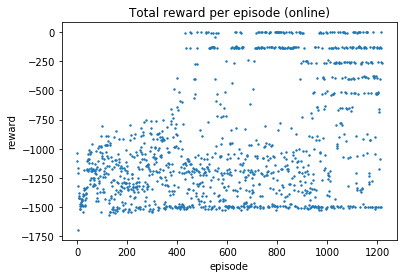

In [89]:
plt.scatter(np.arange(len(episode_rewards)), episode_rewards, s=2)
plt.title("Total reward per episode (online)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

In [69]:
state = env.reset()

In [70]:
m = actor.model(t(state))
m

tensor([-0.2877,  0.0264, -0.1438,  0.5027,  1.0066, -0.1544,  0.4802, -0.1561,
         0.2354, -0.0054,  0.3285,  0.1031,  0.7267, -0.0575, -0.0306,  0.7434,
         0.4232, -0.1967,  0.2230, -0.1707,  0.0087, -0.2611,  0.7855,  0.3474,
         0.8359,  0.1104, -0.2812, -0.2202,  0.3276,  0.1480, -0.3086, -0.1037],
       grad_fn=<MulBackward0>)

In [71]:
actor.stds_head(m)

tensor([0.0014], grad_fn=<SoftplusBackward>)

In [72]:
env.close()

## diario

*
* architecture review
  all tanh, std out of the network, from 32 => 64 neuros
* gradient clip

scale going up always, changed lr (increased), nsteps (5 => 16), gamma (0.95 => 0.98)